In [1]:
!pip install gdown --quiet

In [ ]:
import gdown
file_id = '1lhAaeQCmk2y440PmagA0KmIVBIysVMwu'
output = "tennis_court.zip"
gdown.download(f'https://drive.google.com/uc?id={file_id}', output, quiet=False)
!unzip tennis_court.zip

In [35]:
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
from torchvision import transforms, models
import json
import os
import numpy as np
import cv2
from PIL import Image
from tqdm import tqdm
import sys
sys.path.append('../')
from tracker import CourtLineDetector

In [2]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
class KeyPointsDataset(Dataset):
  def __init__(self,data_dir,train=False,val=False):
    self.image_dir = os.path.join(data_dir,'images')
    if train:
      self.json_file = os.path.join(data_dir,'data_train.json')
    if val:
      self.json_file = os.path.join(data_dir,'data_val.json')
    with open(self.json_file,'r') as f:
      self.data = json.load(f)
    self.transforms = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize(mean = [0.485, 0.456, 0.406],std = [0.229, 0.224, 0.225])
    ])

  def __len__(self):
    return len(self.data)

  def __getitem__(self,idx):
    item = self.data[idx]
    imagefile = item['id'] + '.png'
    img = cv2.imread(os.path.join(self.image_dir,imagefile))
    h,w = img.shape[0], img.shape[1]
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    img = self.transforms(img)
    kps = np.array(item['kps']).astype(np.float32)
    kps = kps.flatten()

    kps[::2] *= 224.0/w
    kps[1::2] *= 224.0/h

    return img,kps

In [6]:
DATA_DIR = '/content/data'
trainset = KeyPointsDataset(DATA_DIR,train=True)
valset = KeyPointsDataset(DATA_DIR,val=True)

In [7]:
trainloader = DataLoader(trainset,batch_size=16,shuffle=True)
valloader = DataLoader(valset,batch_size=16,shuffle = True)

In [3]:
model = models.resnet34(pretrained = True)

e:\D\ML_DL\Projects\Tennis_Analysis\env\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
e:\D\ML_DL\Projects\Tennis_Analysis\env\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [4]:
model.fc = nn.Linear(model.fc.in_features, out_features = 14*2)        # training for finding the 14 * 2 key points in court

In [ ]:
model.to(DEVICE)

In [11]:
EPOCHS = 20
criterion = nn.MSELoss()

In [12]:
optimizer = torch.optim.Adam(model.parameters(),lr=1e-4)

In [13]:
for epoch in tqdm(range(EPOCHS)):
  model.train()
  total_loss = 0.0
  for i,(img,kps) in enumerate(trainloader):
    img = img.to(DEVICE)
    kps = kps.to(DEVICE)
    optimizer.zero_grad()
    outputs = model(img)
    loss = criterion(outputs,kps)
    loss.backward()
    optimizer.step()
    total_loss += loss.item() * img.size(0)
  epoch_loss = total_loss/len(trainloader)
  print(f'Epoch {epoch+1}/{EPOCHS}, loss: {round(epoch_loss,3)}')

  5%|▌         | 1/20 [03:40<1:09:41, 220.05s/it]

Epoch 1/20, loss: 179531.593


 10%|█         | 2/20 [07:10<1:04:17, 214.31s/it]

Epoch 2/20, loss: 85250.216


 15%|█▌        | 3/20 [10:34<59:28, 209.90s/it]  

Epoch 3/20, loss: 32768.162


 20%|██        | 4/20 [13:59<55:25, 207.83s/it]

Epoch 4/20, loss: 9730.656


 25%|██▌       | 5/20 [17:24<51:39, 206.65s/it]

Epoch 5/20, loss: 2546.586


 30%|███       | 6/20 [20:47<47:57, 205.57s/it]

Epoch 6/20, loss: 1008.164


 35%|███▌      | 7/20 [24:11<44:24, 204.97s/it]

Epoch 7/20, loss: 696.116


 40%|████      | 8/20 [27:34<40:51, 204.31s/it]

Epoch 8/20, loss: 501.765


 45%|████▌     | 9/20 [30:57<37:22, 203.88s/it]

Epoch 9/20, loss: 354.537


 50%|█████     | 10/20 [34:22<34:02, 204.23s/it]

Epoch 10/20, loss: 276.302


 55%|█████▌    | 11/20 [37:45<30:35, 203.93s/it]

Epoch 11/20, loss: 223.425


 60%|██████    | 12/20 [41:10<27:13, 204.19s/it]

Epoch 12/20, loss: 187.939


 65%|██████▌   | 13/20 [44:34<23:49, 204.17s/it]

Epoch 13/20, loss: 174.103


 70%|███████   | 14/20 [47:59<20:26, 204.38s/it]

Epoch 14/20, loss: 168.994


 75%|███████▌  | 15/20 [51:23<17:02, 204.45s/it]

Epoch 15/20, loss: 147.544


 80%|████████  | 16/20 [54:48<13:38, 204.62s/it]

Epoch 16/20, loss: 123.773


 85%|████████▌ | 17/20 [58:14<10:14, 204.80s/it]

Epoch 17/20, loss: 123.42


 90%|█████████ | 18/20 [1:01:37<06:49, 204.52s/it]

Epoch 18/20, loss: 117.245


 95%|█████████▌| 19/20 [1:05:02<03:24, 204.45s/it]

Epoch 19/20, loss: 114.721


100%|██████████| 20/20 [1:08:26<00:00, 205.31s/it]

Epoch 20/20, loss: 101.437


In [15]:
torch.save(model.state_dict(), 'keypoints.pth')

In [6]:
model.load_state_dict(torch.load('E:\D\ML_DL\Projects\Tennis_Analysis\saved_models\KEYPOINTSMODEL\keypoints.pth',map_location=DEVICE))

<All keys matched successfully>

In [7]:
transforms = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize(mean = [0.485, 0.456, 0.406],std = [0.229, 0.224, 0.225])
    ])

In [61]:
img = cv2.imread('E:\D\ML_DL\Projects\Tennis_Analysis\data\image.png')

In [76]:
from tracker import CourtLineDetector

In [77]:
detector = CourtLineDetector('E:\D\ML_DL\Projects\Tennis_Analysis\saved_models\KEYPOINTSMODEL\keypoints.pth')

In [78]:
kps = detector.predict(img)

In [65]:
frame = detector.draw_points(img,kps)

In [79]:
kps

array([    0.96169,     0.28359,      2.1371,     0.28367,     0.45422,     0.81232,      2.6374,     0.81173,      1.1086,     0.28343,     0.72645,     0.81228,      1.9889,     0.28359,      2.3638,     0.81227,      1.0562,      0.3573,      2.0398,     0.35728,     0.86525,     0.62185,      2.2266,     0.62159,
            1.5479,     0.35716,      1.5442,     0.62194], dtype=float32)

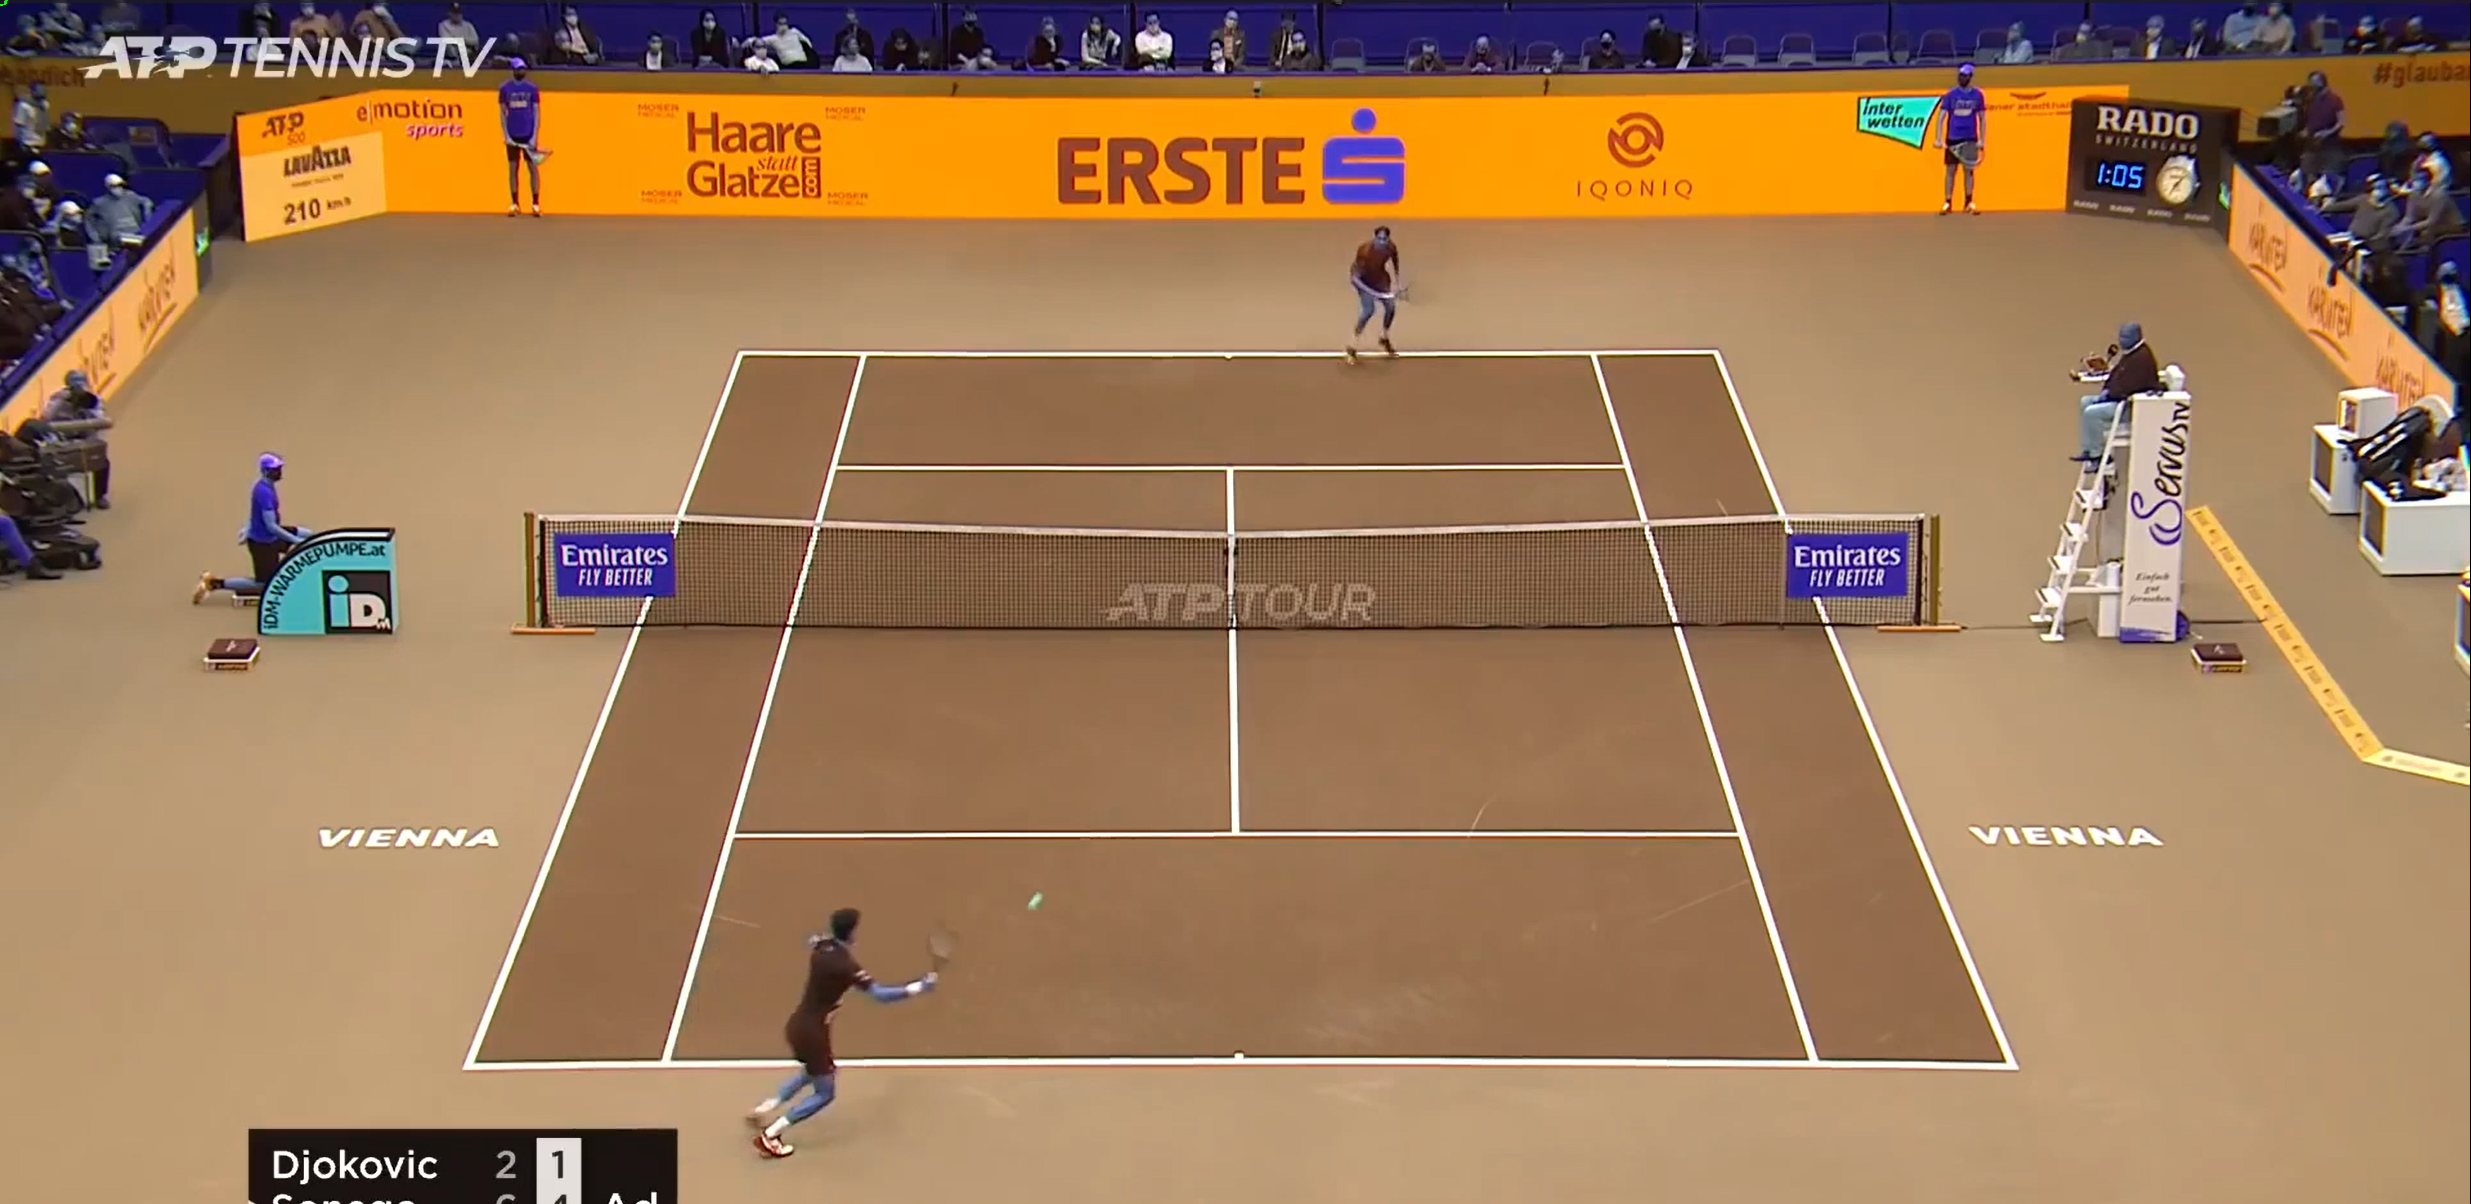

In [63]:
Image.fromarray(frame)

In [1]:
heh = {
    1: [5,3,5,2]
}

In [2]:
heh.get(1)

[5, 3, 5, 2]